<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">


---
<h3>Jon Amelibia, Iker Cumplido, Aitor Hernandez, Daniel Puente and Iñigo Ugarte

## Index
---

- <a href='#1'><ins>1. Loading of Libraries and Data<ins></a>
- <a href='#2'><ins>2. Preprocessing data to enter it to the GAN<ins></a>
- <a href='#3'><ins>3. GAN architecture<ins> </a>
- <a href='#4'><ins>4. Re-train models with the augmented data<ins></a>

### <a id='1'>1. Loading of Libraries and Data</a>
---

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function, division

In [2]:
from functions import ResultsFunctions as rf
from functions import LstmGansFunctions as lfg
from functions import SixthBatteryFunctions as sbf

Paths

In [3]:
path_origin, path_processed = "../02_data/original_data/", "../02_data/processed_data/"
models_path, models_path_normal = "../03_models/gans_models/", "../03_models/models/"
palette = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']
cells = [f'\Cell{x}\*' for x in range(1, 9)]
font = {'size': 16, 'color': 'black', 'weight': 'bold'}

Data

In [4]:
df_desc_final_pickle_load = pd.read_pickle(path_processed + 'df_desc_final.pkl')
df_desc_final_pickle = df_desc_final_pickle_load[df_desc_final_pickle_load.RUL >= 0 ]
df_desc_final_pickle["RUL"] = df_desc_final_pickle["RUL"].astype(float)
print(df_desc_final_pickle.shape)

(390, 41)


### <a id='2'>2. Prepare model</a>
---

We create the X to have the scalar trained, and then use it in the GANs to generate the synthetic data.

In [5]:
X_train, num_steps, quantiles_final = [], 10, []
for i in [1,2,3,4,5,7,8]:
    batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
    batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
    quantiles = []
    for j in range(1, len(batery_df) - num_steps):
        X_train.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].values))
        
X_train = np.array(X_train)
X_train = np.stack(X_train, axis=0)

scaler = pickle.load(open(models_path_normal + 'scaler_gans.pkl', 'rb'))
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

We construct a new GAN, but without the sixth battery

In [6]:
lstmgan = lfg.LSTMGAN(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 11, 256)          174080    
 l)                                                              
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 11, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 256)           0

We train the model and looking the best one we select it. Then we change the name manually to `GAN_LSTM_no_6`.    
These kind of models depends a lot on the random initialization, so we have to train several models and select the best one. So as to select the best one, there is no a unified metric, so we have to look at the loss and the validation loss when training with that synthetic data.

In [ ]:
lstmgan.train(epochs=150000, batch_size=128, save_interval=20)

Once we have the scaler trained we divide the data into train, validation and test sets.  
* Train:      **Cells 1,2,3,5**
* Validation: **Cells 4,7,8**
* Test:       **Cells 6**

In [6]:
x, y, X_test, y_test, X_val, y_val = [], [], [], [], [], []

for i in range(1,9):
    batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
    batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
    quantiles = []
    if i == 6:
        for j in range(1, len(batery_df) - num_steps):
            X_test.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
            y_test.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1]]))

    if (i in [4, 8, 7]):
        for j in range(1, len(batery_df) - num_steps):
            X_val.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
            y_val.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1]]))

    else:
        for j in range(1, len(batery_df) - num_steps):
            x.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
            y.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1]]))
        
X_train, y_train, X_test, y_test, X_val, y_val = np.array(x), np.array(y), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)
y_train[:,0], y_test[:,0], y_val[:, 0] = y_train[:,0].astype(float), y_test[:,0].astype(float), y_val[:,0].astype(float)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((178, 11, 40), (178, 1), (33, 11, 40), (33, 1), (124, 11, 40), (124, 1))

We create random noise to feed the generator.

In [7]:
batch_size = 128
random = np.random.normal(0, 1, (batch_size, X_train.shape[1], 41))
from keras.models import load_model
gan_model = load_model(models_path + "GAN_LSTM_no_6.h5")
X_train_augmented = gan_model.predict(random)
X_train_augmented = scaler.inverse_transform(X_train_augmented.reshape(-1, X_train_augmented.shape[-1])).reshape(X_train_augmented.shape)

4/4 [==============================] - 6s 25ms/step


We add the synthetic data to the original data and we normalize it again.   
Then we load the scaler saved not to create it again

In [8]:
scaler2 = pickle.load(open(models_path_normal + 'scaler.pkl', 'rb'))

In [9]:
X_train = scaler2.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_train_augmented = scaler2.transform(X_train_augmented[:,:,:-1].reshape(-1, X_train_augmented[:,:,:-1].shape[-1])).reshape(X_train_augmented[:,:,:-1].shape)

new_X_train, new_y_train = np.concatenate((X_train, X_train_augmented), axis = 0), np.concatenate((y_train, X_train_augmented[:,:,-1][:,-1].reshape(-1,1)), axis = 0)

X_val = scaler2.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler2.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

new_X_train.shape, new_y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((306, 11, 40), (306, 1), (124, 11, 40), (124, 1), (33, 11, 40), (33, 1))

### <a id='3'>3. Model</a>
---

We will train the model that has been selected as best. Nonetheless, in these case, some dropout layers have been added to avoid overfitting.   
Finally, the model has been trained through a lot of epochs to achieve a good result. 

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=100000, restore_best_weights=True)
checkpoint_new = keras.callbacks.ModelCheckpoint(models_path_normal +'Bidirectional_LSTM_adapted_GAN_No_6.h5', verbose = 0, save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=200, factor=0.9, min_lr=0.00001)

model_lstm_bidirectional = keras.Sequential()
forward_layer = keras.layers.LSTM(624, activation = keras.layers.LeakyReLU(alpha=0.3), recurrent_dropout = 0.05)
backward_layer = keras.layers.LSTM(416, activation = tf.keras.layers.PReLU('zeros'), recurrent_dropout = 0.05, go_backwards = True)
model_lstm_bidirectional.add(keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(X_train.shape[1], X_train.shape[2]) ))
model_lstm_bidirectional.add(keras.layers.Dropout(0.35))
model_lstm_bidirectional.add(keras.layers.Dense(1, activation='relu'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_lstm_bidirectional.compile(loss=rf.customLoss, optimizer= optimizer, metrics=['mae'])
historyBiLSTM = model_lstm_bidirectional.fit(X_train, y_train, epochs=200000, batch_size=16, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkpoint_new, early_stopping])

### <a id='4'>4. Results</a>
---

In [10]:
model = load_model(models_path_normal + "Bidirectional_LSTM_adapted_GAN_No_6.h5", custom_objects={'customLoss': rf.customLoss})

ypred = model.predict(X_test)
print('Test -->', r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)), rf.customLoss_numpy(y_test, ypred))
ypred_train = model.predict(X_train)
print('Train -->', r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)), rf.customLoss_numpy(y_train, ypred_train))

2/2 [==============================] - 1s 44ms/step
Test --> 0.9407555208324171 232.66902935143673 253.09257000332838 20141576.65570788
6/6 [==============================] - 1s 87ms/step
Train --> 0.9538856274476362 224.85506927833129 248.16105208105063 19364305.034554906


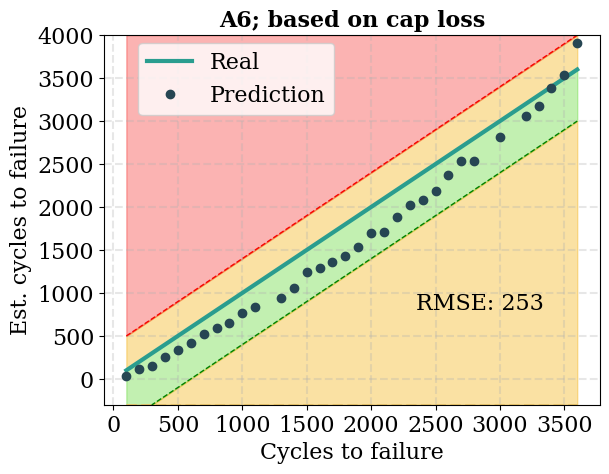

In [70]:
sbf.line_plot_result(ypred, y_test)

----